In [703]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Read Data

In [704]:
diabetes_data = pd.read_csv("pima-indians-diabetes-database/diabetes.csv")
diabetes_data = diabetes_data.astype(float)

### Exploratory Data Analysis

In [705]:
# View of Data

diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [706]:
# Column Stats

diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [707]:
# Look for Null Values

diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null float64
Glucose                     768 non-null float64
BloodPressure               768 non-null float64
SkinThickness               768 non-null float64
Insulin                     768 non-null float64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null float64
Outcome                     768 non-null float64
dtypes: float64(9)
memory usage: 54.1 KB


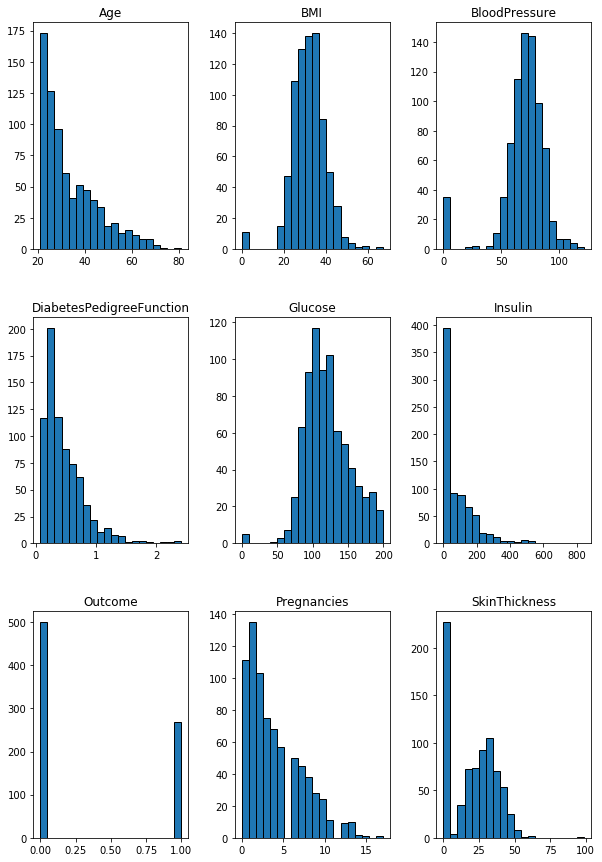

In [708]:
# Histograms

diabetes_data.hist(figsize=(10, 15), edgecolor = 'black', grid = False, bins = 20)
plt.show()

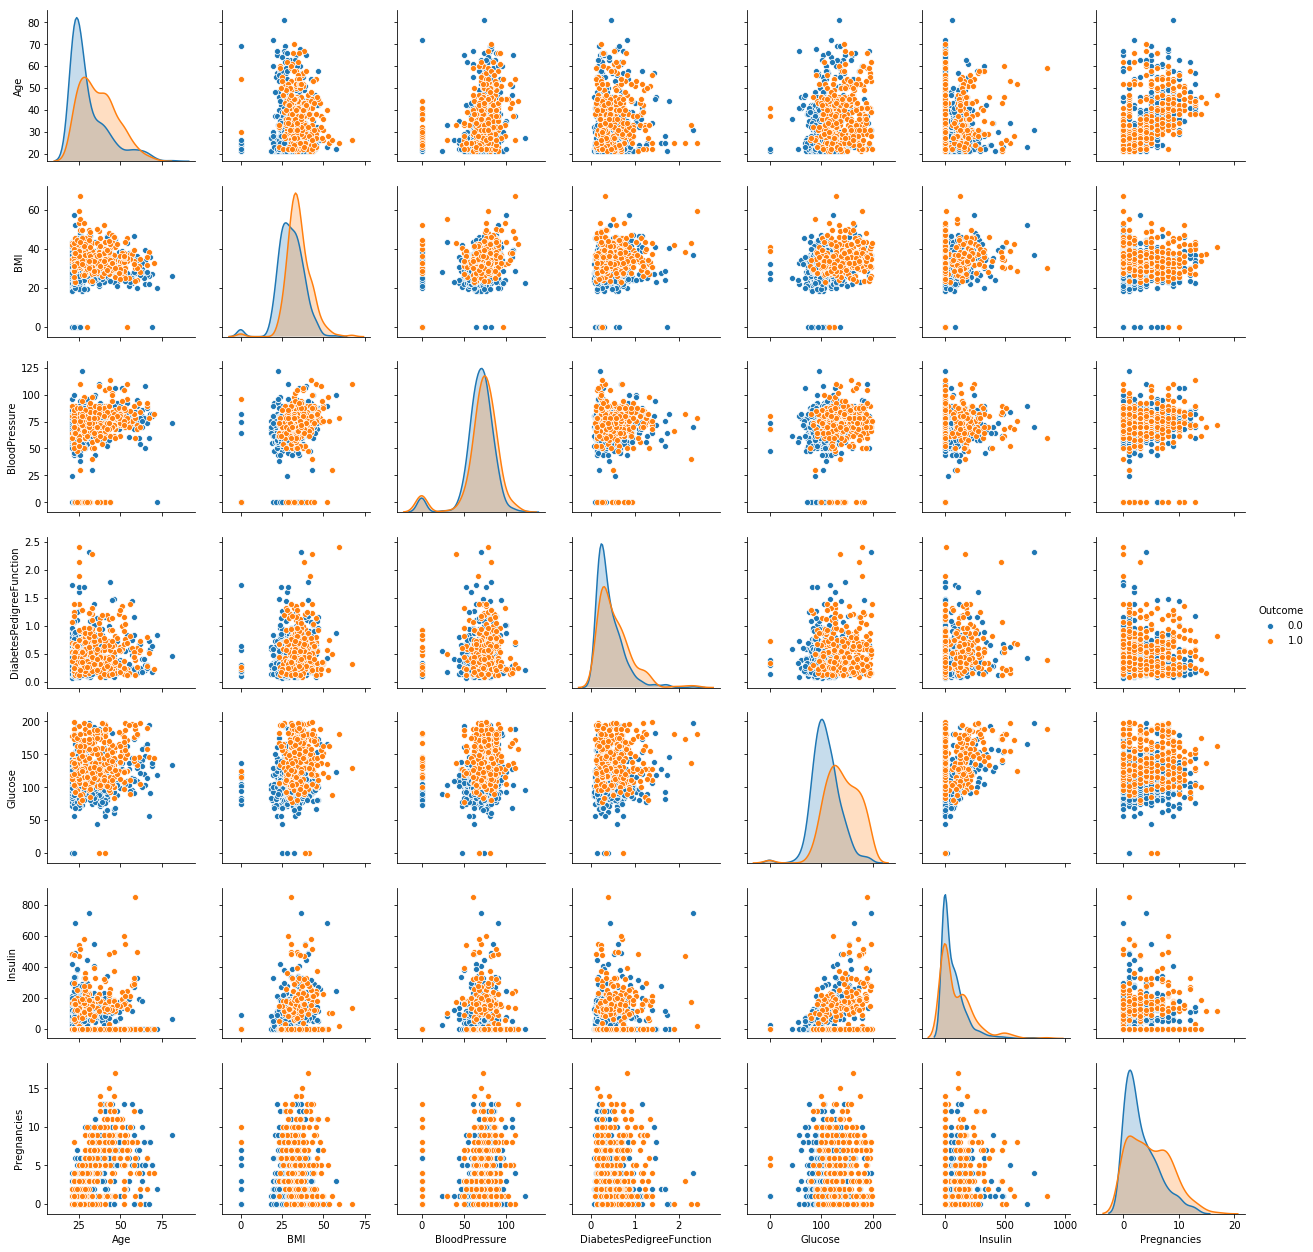

In [709]:
# Pair Plots 

diabetes_data_noNA = diabetes_data.dropna()

sns.pairplot(diabetes_data_noNA, hue = 'Outcome', vars = ['Age', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', \
                                                    'Glucose', 'Insulin', 'Pregnancies'], dropna = True)
plt.show()

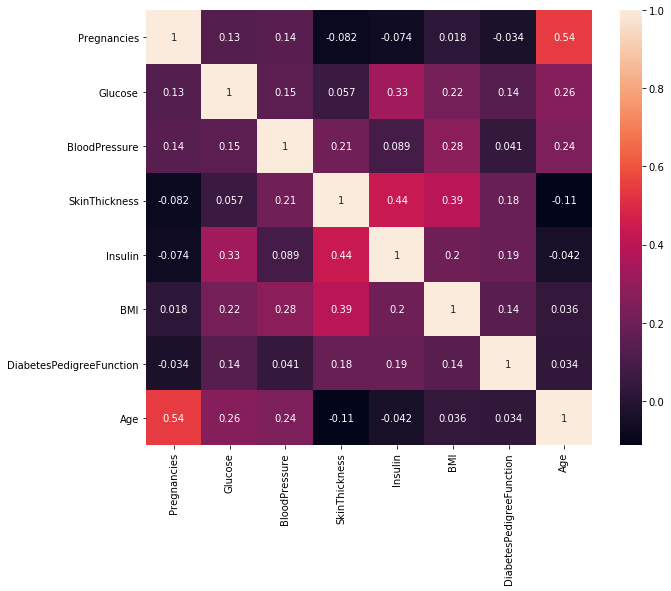

In [710]:
# Correlation Matrix

plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_data[diabetes_data.columns[:8]].corr(), annot=True)
plt.show()

### Basic Model Implementation

In [876]:
# Create training and test data

from sklearn.model_selection import train_test_split

X_train_init, X_test_init = train_test_split(diabetes_data, test_size = 0.2, random_state = 1)

y_train = X_train_init.Outcome
X_train = X_train_init.drop("Outcome", axis = 1)

y_test = X_test_init.Outcome
X_test = X_test_init.drop("Outcome", axis = 1)

In [877]:
# Try Different Models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


models = [LogisticRegression(solver = 'liblinear'), GaussianNB(), \
          RandomForestClassifier(n_estimators = 100, max_depth = 5), \
          ExtraTreesClassifier(n_estimators = 100, max_depth = 5), XGBClassifier()]

model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Extra Trees', 'XGBoost']

k_folds = 5

In [878]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.765487568413
Naive Bayes :  0.749253201945
Random Forest :  0.757357057177
Extra Trees :  0.742669168892
XGBoost :  0.737778222045


In [879]:
from sklearn import metrics

print("Test Set:")
for i, model in enumerate(models):
    predictions = model.fit(X_train, y_train).predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    print(model_names[i], ": ", accuracy)

Test Set:
Logistic Regression :  0.779220779221
Naive Bayes :  0.772727272727
Random Forest :  0.792207792208
Extra Trees :  0.746753246753
XGBoost :  0.798701298701


### Impute Missing Values

In [880]:
X_train_init_null = X_train_init.copy()
X_test_init_null = X_test_init.copy()

X_train_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
    X_train_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)
    
X_test_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
    X_test_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)
    

#X_train_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']] = \
#X_train_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].apply(np.log)

#X_test_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']] = \
#X_test_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].apply(np.log)

In [881]:
# Impute missing values

diabetes_median = X_train_init_null[X_train_init_null.Outcome == 1]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()
    
diabetes_mean = X_train_init_null[X_train_init_null.Outcome == 1]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].mean()
    
diabetes_std = X_train_init_null[X_train_init_null.Outcome == 1]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].std()
    

no_diabetes_median = X_train_init_null[X_train_init_null.Outcome == 0]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()
    
no_diabetes_mean = X_train_init_null[X_train_init_null.Outcome == 0]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].mean()
    
no_diabetes_std = X_train_init_null[X_train_init_null.Outcome == 0]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].std()
    
    
print("Median of People with Diabetes:")
print(diabetes_median, '\n')

print("Mean of People with Diabetes:")
print(diabetes_mean, '\n')

print("Standard Deviation of People with Diabetes:")
print(diabetes_std, '\n')


print("Median of People without Diabetes:")
print(no_diabetes_median, '\n')

print("Mean of People without Diabetes:")
print(no_diabetes_mean, '\n')

print("Standard Deviation of People without Diabetes:")
print(no_diabetes_std, '\n')

    
print("Difference Between Medians of People with and without Diabetes:")
print(diabetes_median - no_diabetes_median, '\n')

print("Difference Between Mean of People with and without Diabetes:")
print(diabetes_mean - no_diabetes_mean)

diabetes_median_array = np.array(diabetes_median)
no_diabetes_median_array = np.array(no_diabetes_median)

diabetes_mean_array = np.array(diabetes_mean)
no_diabetes_mean_array = np.array(no_diabetes_mean)

diabetes_std_array = np.array(diabetes_std)
no_diabetes_std_array = np.array(no_diabetes_std)

Median of People with Diabetes:
Glucose          140.0
BloodPressure     74.0
SkinThickness     32.0
Insulin          175.0
BMI               34.3
dtype: float64 

Mean of People with Diabetes:
Glucose          142.032864
BloodPressure     74.828283
SkinThickness     32.338129
Insulin          212.466019
BMI               35.074408
dtype: float64 

Standard Deviation of People with Diabetes:
Glucose           29.710773
BloodPressure     12.861654
SkinThickness     10.307978
Insulin          132.670225
BMI                6.465322
dtype: float64 

Median of People without Diabetes:
Glucose          107.0
BloodPressure     70.0
SkinThickness     27.0
Insulin           95.0
BMI               30.1
dtype: float64 

Mean of People without Diabetes:
Glucose          111.052764
BloodPressure     70.968992
SkinThickness     27.024648
Insulin          129.970732
BMI               30.667677
dtype: float64 

Standard Deviation of People without Diabetes:
Glucose           25.086143
BloodPressure   

In [882]:
X_train_null = X_train_init_null.drop("Outcome", axis = 1)
X_test_null = X_test_init_null.drop("Outcome", axis = 1)

In [883]:
def impute_nan(input_row):
    
    input_row_short = input_row[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]
    missing_indexes = np.argwhere(np.isnan(input_row_short))

    row_no_nan = np.array([i for j, i in enumerate(input_row_short) if j not in missing_indexes])
    diabetes_median_no_nan = np.array([i for j, i in enumerate(diabetes_median_array) if j not in missing_indexes])
    no_diabetes_median_no_nan = np.array([i for j, i in enumerate(no_diabetes_median_array) if j not in missing_indexes])
    
    euclidean_diabetes = np.linalg.norm(row_no_nan - diabetes_median_no_nan)
    euclidean_no_diabetes = np.linalg.norm(row_no_nan - no_diabetes_median_no_nan)
    
    min_dist = min(euclidean_diabetes, euclidean_no_diabetes)
    
    if min_dist == euclidean_diabetes:
        for val in missing_indexes:
            input_row_short[val] = diabetes_median_array[val[0]]
            #input_row_short[val] = np.random.normal(diabetes_mean_array[val[0]], diabetes_std_array[val[0]], 1)
    else:
        for val in missing_indexes:
            input_row_short[val] = no_diabetes_median_array[val[0]]
            #input_row_short[val] = np.random.normal(no_diabetes_mean_array[val[0]], no_diabetes_std_array[val[0]], 1)
            
    input_row[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = input_row_short
            
    return input_row

In [884]:
X_train_imputed = X_train_null.copy()
X_test_imputed = X_test_null.copy()

X_train_imputed = X_train_imputed.apply(impute_nan, axis = 1)
X_test_imputed = X_test_imputed.apply(impute_nan, axis = 1)

In [885]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train_imputed, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.752491906463
Naive Bayes :  0.74273602387
Random Forest :  0.758877094324
Extra Trees :  0.745921846315
XGBoost :  0.750773454059


### New Features

In [886]:
X_train_addedColumns = X_train_imputed.copy()
X_test_addedColumns = X_test_imputed.copy()

In [887]:
### Add new features

def add_features(initial_df):  
    # Obesity
    initial_df.loc[:,'Obesity'] = 'None'
    initial_df.loc[(initial_df['BMI'] <= 18.5), 'Obesity'] = 'Underweight'
    initial_df.loc[(initial_df['BMI'] >= 18.5) & \
                             (initial_df['BMI'] < 25), 'Obesity'] = 'Normal'
    initial_df.loc[(initial_df['BMI'] >= 25) & \
                             (initial_df['BMI'] < 30), 'Obesity'] = 'Overweight'
    initial_df.loc[(initial_df['BMI'] >= 30), 'Obesity'] = 'Obese'

    # Blood Pressure
    initial_df.loc[:, 'Hypertension'] = 'None'
    initial_df.loc[(initial_df['BloodPressure'] < 80), 'Hypertension'] = 'Normal or Elevated'
    initial_df.loc[(initial_df['BloodPressure'] >= 80) & \
                             (initial_df['BloodPressure'] < 90), 'Hypertension'] = 'Hypertension Stage 1'
    initial_df.loc[(initial_df['BloodPressure'] >= 90), 'Hypertension'] = 'Hypertension Stage 2'

    # OGTT test
    initial_df.loc[:, 'OGTT'] = 'None'
    initial_df.loc[(initial_df['Glucose'] < 140), 'OGTT'] = 'Normal'
    initial_df.loc[(initial_df['Glucose'] >= 140) & \
                             (initial_df['Glucose'] < 200), 'OGTT'] = 'Pre-Diabetes'
    initial_df.loc[(initial_df['Glucose'] >= 200), 'OGTT'] = 'Diabetes'

    # Polynomials
    initial_df['Glucose_squared'] = initial_df['Glucose'] ** 2
    initial_df['Glucose_cubed'] = initial_df['Glucose'] ** 3

    initial_df['BMI_squared'] = initial_df['BMI'] ** 2
    initial_df['BMI_cubed'] = initial_df['BMI'] ** 3

    initial_df['DiabetesPedigreeFunction_squared'] = initial_df['DiabetesPedigreeFunction'] ** 2
    initial_df['DiabetesPedigreeFunction_cubed'] = initial_df['DiabetesPedigreeFunction'] ** 3

    # Interactions
    initial_df['Pregnancies_x_Age'] = initial_df['Pregnancies'] * initial_df['Age']
    initial_df['BP_x_Glucose'] = initial_df['BloodPressure'] * initial_df['Glucose']
    initial_df['DPF_x_Glucose'] = initial_df['DiabetesPedigreeFunction'] * initial_df['Glucose']
    initial_df['BMI_x_Age'] = initial_df['BMI'] * initial_df['Age']
    
    return initial_df
    
X_train_addedColumns = add_features(X_train_addedColumns)
X_test_addedColumns = add_features(X_test_addedColumns)

In [888]:
# Standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']] = \
    scaler.fit_transform(X_train_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']])
    
X_test_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']] = \
    scaler.fit_transform(X_test_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']])

In [889]:
# Encoding

X_train_encoded = pd.get_dummies(X_train_addedColumns)
X_test_encoded = pd.get_dummies(X_test_addedColumns)

In [890]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train_encoded, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.740977372492
Naive Bayes :  0.653167765152
Random Forest :  0.750825906197
Extra Trees :  0.747481007597
XGBoost :  0.749147007864


### Feature Selection

In [891]:
# feature importance
from xgboost import plot_importance
import eli5
from eli5.sklearn import PermutationImportance

model_importance = XGBClassifier()

model_importance.fit(X_train_encoded, y_train)

#perm = PermutationImportance(model_importance, cv=k_folds)
#perm.fit(X_train_encoded, y_train)
#eli5.show_weights(perm)

#plot_importance(model_importance)
#plt.show()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [892]:
feature_scores = pd.DataFrame({'Features': X_train_encoded.columns, 'F Score': model_importance.feature_importances_})

sorted_features = feature_scores.sort_values('F Score', ascending = False)

top_features = list(sorted_features.Features[0:6])

sorted_features.head()

,F Score,Features
1,0.216864,Glucose
17,0.146590,BMI_x_Age
5,0.081636,BMI
16,0.076336,DPF_x_Glucose
4,0.075118,Insulin


In [893]:
X_train_selected = X_train_encoded[top_features]
X_test_selected = X_test_encoded[top_features]

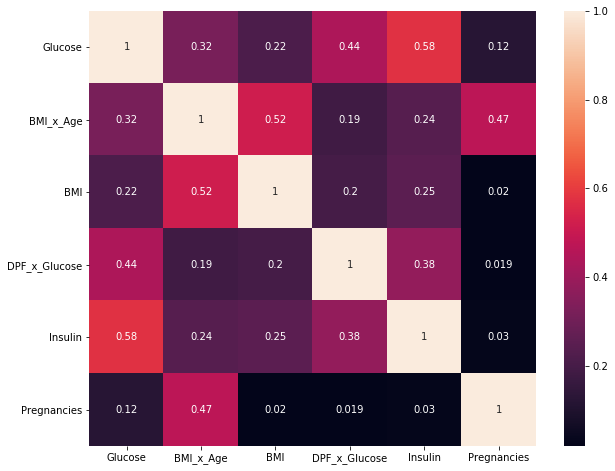

In [894]:
# Correlation Matrix

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_selected.corr(), annot=True)
plt.show()

In [895]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train_selected, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.770325848155
Naive Bayes :  0.752518777435
Random Forest :  0.770285649181
Extra Trees :  0.76871294493
XGBoost :  0.768686933829


### Hyperparameter Tuning

In [905]:
### Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV

# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 30)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 8)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Minimum loss reduction per node
gamma = [0, 0.5, 1, 1.5, 2, 5]


# Grid Parameters
rf_random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

xgb_random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma}


In [906]:
# Grid Search for Random Forest
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), \
                               param_distributions = rf_random_grid, \
                               n_iter = 200, \
                               cv = k_folds)

rf_random.fit(X_train_selected, y_train)

rf_best_random = rf_random.best_estimator_

In [907]:
# Grid Search for Extra Trees
et_random = RandomizedSearchCV(estimator = ExtraTreesClassifier(), \
                               param_distributions = rf_random_grid, \
                               n_iter = 200, \
                               cv = k_folds)

et_random.fit(X_train_selected, y_train)

et_best_random = et_random.best_estimator_

In [908]:
# Grid Search for XGBoost

xgb_random = RandomizedSearchCV(estimator = XGBClassifier(), \
                               param_distributions = xgb_random_grid, \
                               n_iter = 200, \
                               cv = k_folds)

xgb_random.fit(X_train_selected, y_train)

xgb_best_random = xgb_random.best_estimator_

In [909]:
models_best = [LogisticRegression(solver = 'liblinear'), GaussianNB(), \
          rf_best_random, et_best_random, xgb_best_random]

In [910]:
print("Cross validation:")
for i, model in enumerate(models_best):
    scores = cross_val_score(model, X_train_selected, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.770325848155
Naive Bayes :  0.752518777435
Random Forest :  0.781694848942
Extra Trees :  0.762221992923
XGBoost :  0.781775031923


In [912]:
print("Test Set:")
for i, model in enumerate(models_best):
    predictions = model.fit(X_train_selected, y_train).predict(X_test_selected)
    accuracy = metrics.accuracy_score(y_test, predictions)
    print(model_names[i], ": ", accuracy)

Test Set:
Logistic Regression :  0.766233766234
Naive Bayes :  0.779220779221
Random Forest :  0.798701298701
Extra Trees :  0.779220779221
XGBoost :  0.818181818182


### Stacking Models

In [913]:
from scipy import stats

# Model Ensemble

model_predict = np.zeros((len(X_train_selected), len(models_best)))

for i, model in enumerate(models):
    
    model_predict[:, i] = cross_val_predict(model, X_train_selected, y_train, cv=k_folds)
    
    #model_predict[:,i] = model.fit(X_train, y_train).predict(X_test)
    
majority_vote = stats.mode(model_predict, axis = 1)[0]
print(metrics.accuracy_score(y_train, majority_vote))

0.770358306189


### Run Test Set

In [914]:
# Model Ensemble

model_predict = np.zeros((len(X_test), len(models_best)))

for i, model in enumerate(models_best):
    
    model_predict[:,i] = model.fit(X_train_selected, y_train).predict(X_test_selected)
    
majority_vote = stats.mode(model_predict, axis = 1)[0]
print(metrics.accuracy_score(y_test, majority_vote))

0.792207792208
